# Going deeper

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf

# Use GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_probability as tfp
import keras as keras
import pandas as pd
import pystan
import scipy.stats as stats
import scipy.signal
import seaborn as sns
import tqdm
import datetime
import sys
import ctypes
import pickle
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from keras import callbacks, optimizers
from IPython.display import display, clear_output, HTML
from numpy import trapz
from scipy.stats import norm

sys.path.append('../')
import src.vimlts_utils_keras as VIMLTS_utils
from src.vimlts import VIMLTS
from src.vigauss_keras import DenseVIGAUSS
from src.vimlts_keras import DenseVIMLTS

tfd=tfp.distributions

print('Tensorflow version: ',tf.__version__, )

Using TensorFlow backend.
Tensorflow version:  2.1.0


## Data generating process

In [2]:
def get_toy_data_3(
    noise_scale,
    train_size,
    test_size,
    true_size,
    use_hole
):
    tf.random.set_seed(2)

    train_xlim = 6.
    test_xlim = 6.5
    true_xlim = 6.5

    # True function
    target_fn = lambda x: np.sin(x)

    # Train samples
    if use_hole:
        half_train_size = train_size // 2
        train_xs_left = tfd.Uniform(low = -train_xlim, high = -train_xlim/3).sample(sample_shape = (half_train_size, 1))
        train_xs_right = tfd.Uniform(low = train_xlim/3, high = train_xlim).sample(sample_shape = (half_train_size, 1))
        train_xs = np.concatenate((train_xs_left, train_xs_right))
    else:
        train_xs = np.linspace(-train_xlim,train_xlim,train_size)
        train_xs = np.reshape(train_xs,[-1,1])


    train_ys = target_fn(train_xs)
    train_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (train_size, 1))

    # Test samples
    test_xs = np.linspace(-test_xlim,test_xlim,test_size)
    test_xs = np.reshape(test_xs,[-1,1])
    test_ys = target_fn(test_xs)
    test_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (test_size, 1))

    # True
    true_xs = np.linspace(-true_xlim, true_xlim, true_size)
    true_xs = np.reshape(true_xs, (true_size, 1))
    true_ys = target_fn(true_xs)


    return train_xs, train_ys, test_xs, test_ys, true_xs, true_ys

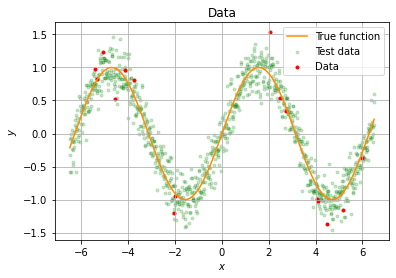

In [3]:
sigma = noise  = .2
num = train_size = 16
test_size = 1000
true_size = 1000

x, y, x_test, y_test, x_true, y_true = get_toy_data_3(sigma, train_size, test_size, true_size,use_hole=1)
y=np.reshape(y,[-1])
y_test=np.reshape(y_test,[-1])

plt.figure()
plt.scatter(x_test,y_test, marker='.', color='g',label=r"Test data",alpha=0.2)
plt.scatter(x,y, marker='.', color='r',label=r"Data")
plt.plot(x_true,y_true,color="darkorange",label=r"True function")
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Data');

## Common hyperparameter

In [34]:
# Number of epochs
epochs=10000

# Number of hidden units for the single hidden layer
num_hidden_units=10

# Number of samples psi to approximate the expected value
#num_samples_per_epoch=1

# Range for the PPD
num_xx=3000
xx = np.linspace(-11, 11, num_xx).reshape(-1, 1)

# Number of predictions for the PPD
num_predictions=1000

# Learning rate and clip norm
lr=0.03
cn=2.

# Train parameters
batch_size = train_size
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches

# Prior
prior_params = {
    'prior_mu': 0., 
    'prior_sigma': 1.
}

## Common functions

In [5]:
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

## VIGAUSS

MFVI with a Gaussian as variational distribution

In [6]:
x_in = Input(shape=(1,),name="VIGAUSS_il")
x_arch = DenseVIGAUSS(units=num_hidden_units, activation='relu', kl_weight=kl_weight, name="VIGAUSS_hl_1", **prior_params )(x_in)
x_arch = DenseVIGAUSS(units=num_hidden_units, activation='relu', kl_weight=kl_weight, name="VIGAUSS_hl_2", **prior_params )(x_arch)
x_arch = DenseVIGAUSS(units=1, kl_weight=kl_weight, name="VIGAUSS_ol", **prior_params)(x_arch)

model_VIGAUSS = Model(x_in, x_arch,name="model_VIGAUSS")

In [7]:
print(model_VIGAUSS.summary())

Model: "model_VIGAUSS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VIGAUSS_il (InputLayer)      (None, 1)                 0         
_________________________________________________________________
VIGAUSS_hl_1 (DenseVIGAUSS)  (None, 10)                40        
_________________________________________________________________
VIGAUSS_hl_2 (DenseVIGAUSS)  (None, 10)                220       
_________________________________________________________________
VIGAUSS_ol (DenseVIGAUSS)    (None, 1)                 22        
Total params: 282
Trainable params: 282
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr), metrics=[neg_log_likelihood])
model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr,clipnorm=cn), metrics=[neg_log_likelihood])

In [9]:
callbacks_VIGAUSS = [
    #callbacks.LearningRateScheduler(lr_scheduler, verbose=0)
]

# Fit the model to the data
hist=model_VIGAUSS.fit(x, y, callbacks=callbacks_VIGAUSS, batch_size=batch_size, epochs=epochs, verbose=0);

## VIMLTS

MFVI with a flexible variational distribution

### functions

In [10]:
def get_lambdas_for_w(layer_weights, from_neuron_layer_bevore, to_neuron):
    """
        Gets the variational parameter for a specific weight
    """  
    try:
        num_param=14
        lambdas=[]
        
        for j in range(int(num_param)):
            lambdas.append(layer_weights[j][from_neuron_layer_bevore][to_neuron])
        return lambdas
    except:
        print("Constellation not existing")


def get_lambdas_for_bias(layer_weights, neuron):
    """
        Gets the variational parameter for a specific bias
    """  
    try:
        num_param=14
        lambdas=[]
 
        for j in range(num_param,num_param*2):
            lambdas.append(layer_weights[j][neuron])
        return lambdas
    except:
        print("Constellation not existing")

In [11]:
x_in = Input(shape=(1,),name="VIMLTS_il")
x_arch = DenseVIMLTS(units=num_hidden_units,
                    activation='relu', 
                    kl_weight=kl_weight, 
                    init_gauss_like=False,
                    using_f3=True,
                    name="VIMLTS_hl_1", **prior_params)(x_in)
x_arch = DenseVIMLTS(units=num_hidden_units,
                    activation='relu', 
                    kl_weight=kl_weight, 
                    init_gauss_like=False,
                    using_f3=True,
                    name="VIMLTS_hl_2", **prior_params)(x_arch)
x_arch = DenseVIMLTS(units=1, 
                    kl_weight=kl_weight, 
                    init_gauss_like=False,
                    using_f3=True,
                    name="VIMLTS_ol", **prior_params)(x_arch)

model_VIMLTS = Model(x_in, x_arch,name="model_VIMLTS")

Tensor("VIMLTS_hl_1/concat_8:0", shape=(10, 1, 10), dtype=float32)
Tensor("VIMLTS_hl_2/concat_8:0", shape=(10, 10, 10), dtype=float32)
Tensor("VIMLTS_ol/concat_8:0", shape=(10, 10, 1), dtype=float32)


Plot an initialization of the variational distribution

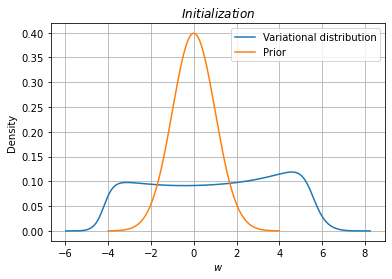

In [12]:
# Get the variational parameters of the model
layer_weights = model_VIMLTS.layers[1].get_weights()[:]
lambdas_before=get_lambdas_for_w(layer_weights,0,0)
# Get the variatioal distribution
distribution_before=VIMLTS_utils.get_target_dist(lambdas_before)

plt.figure()
plt.plot(distribution_before[1],distribution_before[0],label=r"Variational distribution")
plt.plot(np.linspace(-4,4,500),tfd.Normal(loc=0,scale=1).prob(np.linspace(-4,4,500)),label=r"Prior")
plt.legend()
plt.grid()
plt.ylabel(r"Density")
plt.xlabel(r"$w$")
plt.title(r'$Initialization$');

In [13]:
print(model_VIMLTS.summary())

Model: "model_VIMLTS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VIMLTS_il (InputLayer)       (None, 1)                 0         
_________________________________________________________________
VIMLTS_hl_1 (DenseVIMLTS)    (None, 10)                280       
_________________________________________________________________
VIMLTS_hl_2 (DenseVIMLTS)    (None, 10)                1540      
_________________________________________________________________
VIMLTS_ol (DenseVIMLTS)      (None, 1)                 154       
Total params: 1,974
Trainable params: 1,974
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
#model_VIMLTS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr), metrics=[neg_log_likelihood])
model_VIMLTS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr,clipnorm=cn), metrics=[neg_log_likelihood])

In [15]:
# Number of checkpoints, to save the variational distribution during the training
checkpoints=50

subepochs=int(epochs/checkpoints)
hist_weights=[]

class callback_save_weights(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # true
        if(epoch%subepochs==0):
            print("checkpoint:\t",int(epoch/subepochs),"\tloss:\t",logs["loss"])
            layer_weights=[]
            for layer in range(np.shape(self.model.layers)[0]):
                layer_weights.append(self.model.layers[layer].get_weights()[:])

            hist_weights.append(layer_weights)


callbacks_VIMLTS = [
        callback_save_weights()
]

# Fit the model to the data
hist_VIMLTS=model_VIMLTS.fit(x, y, callbacks=callbacks_VIMLTS, batch_size=batch_size, epochs=epochs, verbose=0)

checkpoint:	 0 	loss:	 239829744.0
checkpoint:	 1 	loss:	 477.3370361328125
checkpoint:	 2 	loss:	 212.28094482421875
checkpoint:	 3 	loss:	 258.3974609375
checkpoint:	 4 	loss:	 198.5255126953125
checkpoint:	 5 	loss:	 242.99685668945312
checkpoint:	 6 	loss:	 284.140869140625
checkpoint:	 7 	loss:	 168.10052490234375
checkpoint:	 8 	loss:	 134.72625732421875
checkpoint:	 9 	loss:	 144.06040954589844
checkpoint:	 10 	loss:	 127.87553405761719
checkpoint:	 11 	loss:	 111.12648010253906
checkpoint:	 12 	loss:	 102.82392883300781
checkpoint:	 13 	loss:	 108.68474578857422
checkpoint:	 14 	loss:	 95.15992736816406
checkpoint:	 15 	loss:	 112.4166030883789
checkpoint:	 16 	loss:	 201.13616943359375
checkpoint:	 17 	loss:	 101.03307342529297
checkpoint:	 18 	loss:	 98.35557556152344
checkpoint:	 19 	loss:	 97.72291564941406
checkpoint:	 20 	loss:	 214.15374755859375
checkpoint:	 21 	loss:	 95.59349060058594
checkpoint:	 22 	loss:	 131.9038848876953
checkpoint:	 23 	loss:	 102.79171752929688

## Analyse the run

### Analyse the loss

Minimum Loss VIMLTS:		 72.74655151367188
Minimum Loss VIMLTS an Epoche:	 4724
Loss nach Training VIMLTS:	 143.1107177734375
Loss nach Training VIGAUSS:	 81.76693725585938


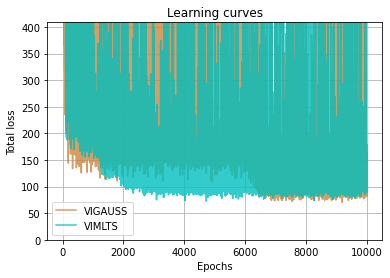

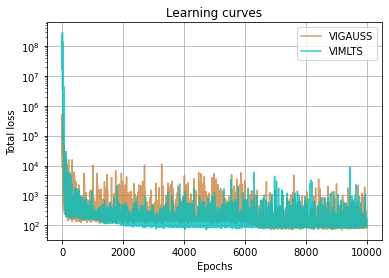

In [16]:
loss_model_VIGAUSS=hist.history['loss'][np.shape(hist.history['loss'])[0]-1]
loss_model_VIMLTS=hist_VIMLTS.history['loss'][np.shape(hist_VIMLTS.history['loss'])[0]-1]
loss_min_VIMLTS=np.min(hist_VIMLTS.history['loss'])
loss_min_epoche_VIMLTS=np.argmin(hist_VIMLTS.history['loss'])

print("Minimum Loss VIMLTS:\t\t",loss_min_VIMLTS)
print("Minimum Loss VIMLTS an Epoche:\t",loss_min_epoche_VIMLTS)
print("Loss nach Training VIMLTS:\t",loss_model_VIMLTS)
print("Loss nach Training VIGAUSS:\t",loss_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['loss'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.ylim([0, loss_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['loss'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['loss'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'Total loss')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.yscale('log')


Show a noise reduced curve

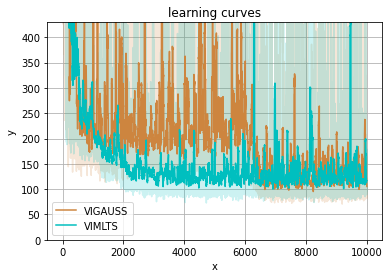

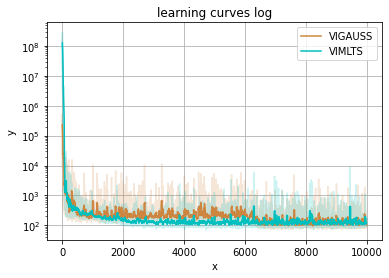

In [17]:
loss_VIGAUSS_hat = scipy.signal.savgol_filter(hist.history['loss'], 31, 1) # window size 31, polynomial order 1
loss_VIMLTS_hat = scipy.signal.savgol_filter(hist_VIMLTS.history['loss'], 31, 1) # window size 31, polynomial order 1

title=r"learning curves"
plt.figure()
plt.plot(hist.history['loss'],color='peru',alpha=0.2)
plt.plot(hist_VIMLTS.history['loss'],color='c',alpha=0.2)
plt.plot(loss_VIGAUSS_hat,color='peru',label=r"VIGAUSS")
plt.plot(loss_VIMLTS_hat,color='c',label=r"VIMLTS")
plt.ylim([0, loss_model_VIMLTS*3])
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.title(title)
plt.show()

title=r"learning curves log"
plt.figure()
plt.plot(hist.history['loss'],color='peru',alpha=0.2)
plt.plot(hist_VIMLTS.history['loss'],color='c',alpha=0.2)
plt.plot(loss_VIGAUSS_hat,color='peru',label=r"VIGAUSS")
plt.plot(loss_VIMLTS_hat,color='c',label=r"VIMLTS")
plt.legend()
plt.grid()
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.yscale('log')
plt.title(title)
plt.show()

### Analyse the NLL

Minimum NLL VIMLTS:		 -2.8791482
Minimum NLL VIMLTS an Epoche:	 3724
NLL nach Training VIMLTS:	 54.47435
NLL nach Training VIGAUSS:	 8.768623


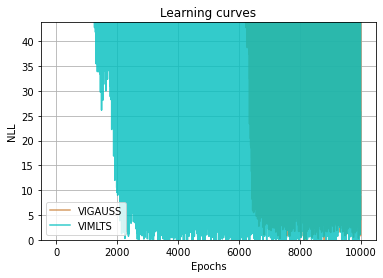

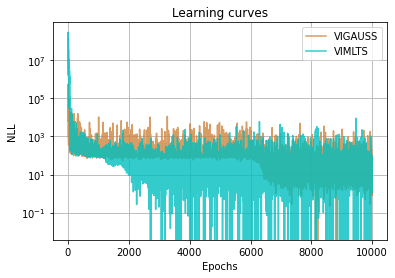

In [18]:
NLL_model_VIGAUSS=hist.history['neg_log_likelihood'][np.shape(hist.history['neg_log_likelihood'])[0]-1]
NLL_model_VIMLTS=hist_VIMLTS.history['neg_log_likelihood'][np.shape(hist_VIMLTS.history['neg_log_likelihood'])[0]-1]
NLL_min_VIMLTS=np.min(hist_VIMLTS.history['neg_log_likelihood'])
NLL_min_epoche_VIMLTS=np.argmin(hist_VIMLTS.history['neg_log_likelihood'])

print("Minimum NLL VIMLTS:\t\t",NLL_min_VIMLTS)
print("Minimum NLL VIMLTS an Epoche:\t",NLL_min_epoche_VIMLTS)
print("NLL nach Training VIMLTS:\t",NLL_model_VIMLTS)
print("NLL nach Training VIGAUSS:\t",NLL_model_VIGAUSS)

plt.figure()
plt.plot(hist.history['neg_log_likelihood'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['neg_log_likelihood'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'NLL')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.ylim([0, NLL_model_VIGAUSS*5])

plt.figure()
plt.plot(hist.history['neg_log_likelihood'],alpha=0.8,color='peru',label=r"VIGAUSS")
plt.plot(hist_VIMLTS.history['neg_log_likelihood'],alpha=0.8,color='c',label=r"VIMLTS")
plt.xlabel(r'Epochs')
plt.ylabel(r'NLL')
plt.title(r'Learning curves');
plt.grid()
plt.legend()
plt.yscale('log')

### Analyse the variational distributions of VIMLTS

In [19]:
# Functions to analyze the variational distribution of VIMLTS

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def slider_layer_fn(show_layer):
    global layer
    layer=show_layer

    layer_weights=model_VIMLTS.layers[layer].get_weights()[:];
    num_neurons=np.shape(layer_weights[0])[1];

    interact(slider_neuron_fn, show_neuron=widgets.IntSlider(min=0, max=num_neurons-1, step=1, value=0));


def slider_neuron_fn(show_neuron):
    global neuron
    global num_neurons_bevore
    neuron=show_neuron

    layer_weights=model_VIMLTS.layers[layer].get_weights()[:];
    num_neurons_bevore=np.shape(layer_weights[0])[0];

    kernel_print_variational_dist_layer_w()
    kernel_print_variational_dist_layer_bias()

    interact(slider_from_neuron_fn, show_from_neuron=widgets.IntSlider(min=0, max=num_neurons_bevore-1, step=1, value=0));


def slider_from_neuron_fn(show_from_neuron):
    global from_neuron
    from_neuron=show_from_neuron
    kernel_print_variational_dist_w()


def kernel_print_variational_dist_layer_w():
    layer_weights = model_VIMLTS.layers[layer].get_weights()[:]
    plt.figure(figsize=(12,8))
    for j in range(num_neurons_bevore):
        lambdas_after=get_lambdas_for_w(layer_weights=layer_weights,from_neuron_layer_bevore=j,to_neuron=neuron)
        distribution_after=VIMLTS_utils.get_target_dist(lambdas_after)
        plt.plot(distribution_after[1],distribution_after[0],label=r"w"+str(layer)+r"_"+str(neuron)+r","+str(j))
    plt.grid()
    plt.xlabel(r"w")
    plt.ylabel(r"q(w)")
    plt.title(r"Variational Dist - Layer "+str(layer)+r" - Neuron "+str(neuron))
    plt.legend()
    return


def kernel_print_variational_dist_layer_bias():
    layer_weights = model_VIMLTS.layers[layer].get_weights()[:]
    lambdas_after=get_lambdas_for_bias(layer_weights=layer_weights,neuron=neuron)
    distribution_after=VIMLTS_utils.get_target_dist(lambdas_after)
    plt.figure()
    plt.plot(distribution_after[1],distribution_after[0])
    plt.grid()
    plt.xlabel(r"w")
    plt.ylabel(r"q(w)")
    plt.title(r"Variational Dist Bias - Layer "+str(layer)+r" - Neuron "+str(neuron))
    return


def kernel_print_variational_dist_w():
    layer_weights = model_VIMLTS.layers[layer].get_weights()[:]
    lambdas_after=get_lambdas_for_w(layer_weights=layer_weights,from_neuron_layer_bevore=from_neuron,to_neuron=neuron)
    distribution_after=VIMLTS_utils.get_target_dist(lambdas_after)
    plt.plot(distribution_after[1],distribution_after[0],label=r"w"+str(layer)+r"_"+str(neuron)+r","+str(from_neuron))
    plt.grid()
    plt.xlabel(r"w")
    plt.ylabel(r"q(w)")
    plt.title(r"Variational Dist - Layer "+str(layer)+r" - Neuron "+str(neuron))
    plt.legend()
    
    # global bnn_ms_q_dist
    # bnn_ms_q_dist=distribution_after[1],distribution_after[0]
    
    return

Select a variational distribution

In [20]:
interact(slider_layer_fn, show_layer=widgets.IntSlider(min=1, max=np.shape(model_VIMLTS.layers)[0]-1, step=1, value=1));

interactive(children=(IntSlider(value=1, description='show_layer', max=3, min=1), Output()), _dom_classes=('wi…

Show the dynamics of the selected variational distribution

C:\Users\Stefa\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


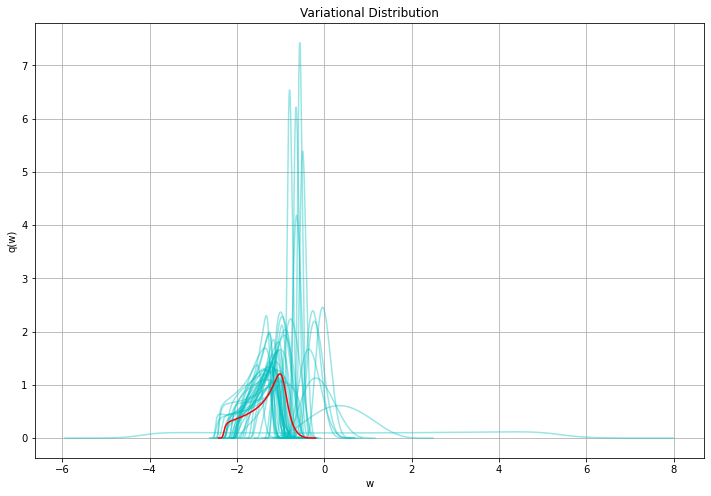

In [21]:
x_min=0
x_max=0
y_min=0
y_max=0

distribution=[]

for i in range(np.shape(hist_weights)[0]):
    layer_weights=hist_weights[i][layer]
    lambdas=get_lambdas_for_w(layer_weights=layer_weights,from_neuron_layer_bevore=from_neuron, to_neuron=neuron)
    dist=VIMLTS_utils.get_target_dist(lambdas)
    if(np.nanmin(dist[1][dist[1] != -np.inf])<x_min):
        x_min=np.min(dist[1])
    if(np.nanmax(dist[1][dist[1] != np.inf])>x_max):
        x_max=np.max(dist[1])
    if(np.nanmin(dist[0][dist[0] != -np.inf])<y_min):
        y_min=np.min(dist[0])
    if(np.nanmax(dist[0][dist[0] != np.inf])>y_max):
        y_max=np.max(dist[0])
    distribution.append(dist)


plt.figure(figsize=(12,8))
plt.title(r"Variational Distribution");
plt.xlabel(r"w");
plt.ylabel(r"q(w)");
for i in range(np.shape(distribution)[0]-1):
    plt.plot(distribution[i][1],distribution[i][0],alpha=0.4,color="c")


plt.plot(distribution[np.shape(distribution)[0]-1][1],distribution[np.shape(distribution)[0]-1][0],color="r")
plt.grid()

Animate the dynamics of the selected variational distribution

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


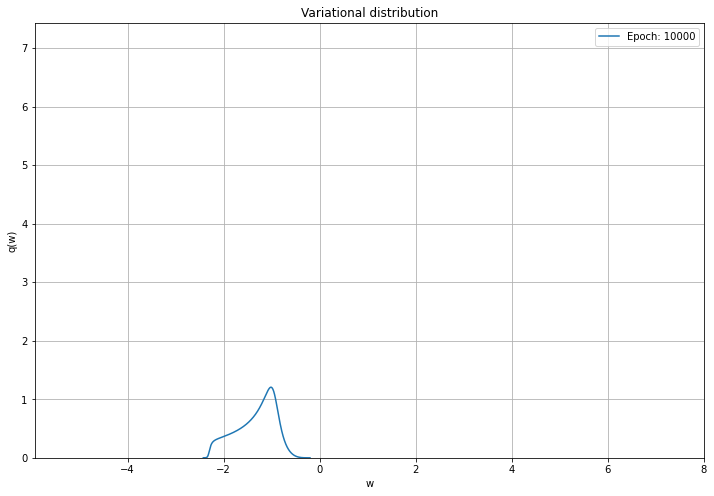

In [22]:
fig, ax = plt.subplots(figsize=(12,8));
fig.patch.set_facecolor('white');
xdata, ydata = [], []
ln, = plt.plot([], []);


def init():
    ax.set_xlim(x_min, x_max);
    ax.set_ylim(y_min, y_max);
    return ln,

def animate(i):
    ln.set_ydata(distribution[i][0]);
    ln.set_xdata(distribution[i][1]);
    ln.set_label(r"Epoch: "+str(i*subepochs+subepochs))
    plt.legend()
    return ln,


ani = animation.FuncAnimation(fig, animate, np.arange(0, checkpoints), init_func=init,
    interval=100, blit=True);

plt.grid();
plt.title(r"Variational distribution");
plt.xlabel(r"w");
plt.ylabel(r"q(w)");
plt.legend()

HTML(ani.to_jshtml())


## Predictive

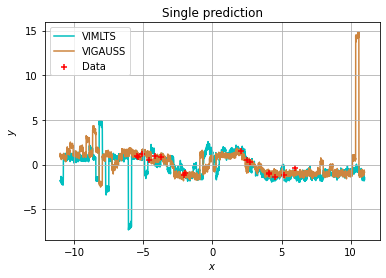

In [23]:
mu_VIGAUSS = model_VIGAUSS.predict(xx)
y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()

mu_VIMLTS = model_VIMLTS.predict(xx)
y_pred_VIMLTS = tfp.distributions.Normal(mu_VIMLTS,sigma).sample()


plt.plot(xx,y_pred_VIMLTS,zorder=0, label=r'VIMLTS',color='c')
plt.plot(xx,y_pred_VIGAUSS,zorder=0,label=r'VIGAUSS',color='peru')
plt.scatter(x, y, marker='+',c='r',zorder=1, label=r'Data')
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Single prediction');

In [35]:
# VIMLTS
y_pred_list = []

# VIGAUSS
y_pred_list_VIGAUSS = []

# Iterate over number of predictions
for i in tqdm.tqdm(range(num_predictions)):
    # VIMLTS
    mu_VIMLTS = model_VIMLTS.predict(xx)
    y_pred_VIMLTS = tfp.distributions.Normal(mu_VIMLTS,sigma).sample()
    y_pred_list.append(y_pred_VIMLTS)

    # VIGAUSS
    mu_VIGAUSS = model_VIGAUSS.predict(xx)
    y_pred_VIGAUSS = tfp.distributions.Normal(mu_VIGAUSS,sigma).sample()
    y_pred_list_VIGAUSS.append(y_pred_VIGAUSS)

# VIMLTS
y_preds = np.concatenate(y_pred_list, axis=1)
y_predictions_mean=np.mean(y_preds,axis=1)
y_predictions_2p5=np.quantile(y_preds,0.025,axis=1)
y_predictions_97p5=np.quantile(y_preds,0.975,axis=1)
y_predictions_50p0=np.quantile(y_preds,0.5,axis=1)

# VIGAUSS
y_preds_VIGAUSS = np.concatenate(y_pred_list_VIGAUSS, axis=1)
y_predictions_mean_VIGAUSS=np.mean(y_preds_VIGAUSS,axis=1)
y_predictions_2p5_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.025,axis=1)
y_predictions_97p5_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.975,axis=1)
y_predictions_50p0_VIGAUSS=np.quantile(y_preds_VIGAUSS,0.5,axis=1)


100%|██████████| 1000/1000 [19:14<00:00,  1.15s/it]


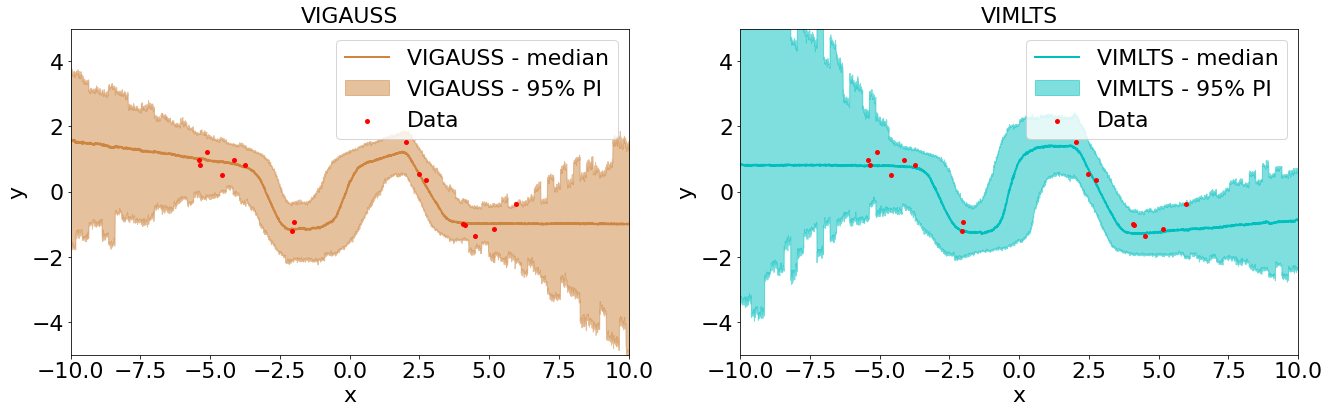

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=False,figsize=(22,6))

#fig.tight_layout(pad=0.0)

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22)  
plt.rc('legend', fontsize=22) 

plt.rcParams['mathtext.fontset'] = 'cm'

linewidth=2

ax1.fill_between(xx.reshape(-1),y_predictions_97p5_VIGAUSS,y_predictions_2p5_VIGAUSS, color='peru', alpha=0.5, label=(r"VIGAUSS - 95% PI"))
#ax1.plot(x_test_hello_world,vimlt_predictions_mean_hello_world, color='peru' ,label=(r"VIMLT - mean"))
ax1.plot(xx,y_predictions_50p0_VIGAUSS, color='peru' ,label=(r"VIGAUSS - median"), linewidth=linewidth)
ax1.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth, zorder=10)
ax1.set_xlim([-10,10])
ax1.set_ylim([-5,5])
ax1.set_xlabel(r'x')
ax1.set_ylabel(r'y')
ax1.set_title(r'VIGAUSS')
ax1.legend()

ax2.fill_between(xx.reshape(-1),y_predictions_97p5,y_predictions_2p5, color='c', alpha=0.5, label=(r"VIMLTS - 95% PI"))
#ax2.plot(x_test_hello_world,vimlts_predictions_mean_hello_world, color='c' ,label=(r"VIMLTS - mean"))
ax2.plot(xx,y_predictions_50p0, color='c' ,label=(r"VIMLTS - median"), linewidth=linewidth)
ax2.scatter(x,y, marker='.', color='r', label=(r"Data"), linewidths=linewidth, zorder=10)
ax2.set_xlim([-10,10])
ax2.set_ylim([-5,5])
ax2.set_xlabel(r'x')
ax2.set_ylabel(r'y')
ax2.set_title(r'VIMLTS')
ax2.legend()

plt.savefig('output/bnn_gd_ppd.svg', format='svg')
plt.savefig('output/bnn_gd_ppd.pdf', format='pdf')

Evaluate the model with the NLL

In [37]:
VIGAUSS_NLL_test_list = []
VIMLTS_NLL_test_list = []
num_evaluations=20

for i in range(num_evaluations):
    clear_output()
    print("round:\t",i,"/",num_evaluations)
    VIGAUSS_NLL_test_list.append(model_VIGAUSS.evaluate(x_test, y_test, batch_size=batch_size)[1])
    VIMLTS_NLL_test_list.append(model_VIMLTS.evaluate(x_test, y_test, batch_size=batch_size)[1])

VIGAUSS_NLL_test_mean=np.mean(VIGAUSS_NLL_test_list)
VIGAUSS_NLL_test_median=np.median(VIGAUSS_NLL_test_list)
VIMLTS_NLL_test_mean=np.mean(VIMLTS_NLL_test_list)
VIMLTS_NLL_test_median=np.median(VIMLTS_NLL_test_list)
print()
print()
print("VIGAUSS NLL test mean:\t\t",VIGAUSS_NLL_test_mean)
print("VIMLTS NLL test mean:\t\t",VIMLTS_NLL_test_mean)


print("VIGAUSS NLL test median:\t",VIGAUSS_NLL_test_median)
print("VIMLTS NLL test median:\t\t",VIMLTS_NLL_test_median)

round:	 19 / 20
1000/1000 [==============================] - 2s 2ms/step


VIGAUSS NLL test mean:		 69.47790145874023
VIMLTS NLL test mean:		 115.24721355438233
VIGAUSS NLL test median:	 60.77221488952637
VIMLTS NLL test median:		 87.95243072509766


# Save the variables

In [38]:
import pandas as pd
import pickle

In [39]:
lambdas_VIMLTS_04_shallow_layer_1=model_VIMLTS.layers[1].get_weights()[:]
lambdas_VIMLTS_04_shallow_layer_2=model_VIMLTS.layers[2].get_weights()[:]
lambdas_VIMLTS_04_shallow_layer_3=model_VIMLTS.layers[3].get_weights()[:]

In [40]:
df_04_lambdas=pd.DataFrame()
df_04_lambdas['lambdas_VIMLTS_04_shallow_layer_1']=lambdas_VIMLTS_04_shallow_layer_1
df_04_lambdas['lambdas_VIMLTS_04_shallow_layer_2']=lambdas_VIMLTS_04_shallow_layer_2
df_04_lambdas['lambdas_VIMLTS_04_shallow_layer_3']=lambdas_VIMLTS_04_shallow_layer_3

In [41]:
pickle.dump( df_04_lambdas, open( "df_04_lambdas.p", "wb" ) )